In [1]:
#! python -m pip install ipympl geocube folium mapclassify -q
## ^^^ do this in the conda env:root kernel
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from geocube.api.core import make_geocube
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 

In [2]:
def distance(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295
    hav = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(hav))

def closest(data, v):
    mn = min(data, key=lambda p: distance(v['Lat'],v['Lon'],p['Lat'],p['Lon']))
    dist = distance(v['Lat'],v['Lon'], mn['Lat'], mn['Lon'])
    print("The closest station is", dist, "km away." )
    return mn

def closest_srch(data, v):
    mn = min(data, key=lambda p: distance(v['Lat'],v['Lon'],p['Lat'],p['Lon']))
    dist = distance(v['Lat'],v['Lon'], mn['Lat'], mn['Lon'])
    mn = pd.DataFrame([mn])
    mn['dist_km'] = dist
    mn['Origin_lat'] = v['Lat']
    mn['Origin_lon'] = v['Lon']
    return mn 

def data_dist(data, v):
    foi = lambda p: distance(v['Lat'],v['Lon'],p['Lat'],p['Lon'])
    return(map(foi, data))

#def within_range(data, dist_max, key = ):
#    return(data <= dist_max)

#def my_update(dat, update):
#    foo = dat.update({"dist": update})
    
#def all_srch(data, v):
#    dists = data_dist(data, v)
#    dists_2 = list(dists)
#    map(my_update(data,dists_2 ))
#    return mn 

In [3]:
#tmp = within_range(st_dict, key = lambda p: data_dist(st_dict, v = foi))
# ----- 
#tmp = data_dist(st_dict, foi)
#tmp_2 = list(tmp)
# ------
#dic = lambda st, dst: st.update({"dist":dst}
#new_st = map(dic, st_dict, tmp)
#list(new_st)
# -----
#tmp_2[0]
#st_dict[0].update({'dist': tmp_2[0]})

#def my_update(dat, update):
#    foo = dat.update({"dist": update})
#    #print(foo)
    #return(foo)

test = map(my_update, st_dict, tmp_2)
st_dict
# -----

NameError: name 'my_update' is not defined

In [ ]:
# CONUS Snapshot data
avail_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/CONUS/2019/Snapshot/*')
#avail_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Schaeffer/2017/Snapshot/*')
avail_dates = [file.split('Snapshot/')[1] for file in avail_files]
print('total number of available dates:',len(avail_dates))
#print('Date range is', avail_dates.loc[0], avail_dates.loc[-1])

In [ ]:
#glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/CONUS/2019/Snapshot/*')

In [8]:
def load_file(date,layer='perimeter',handle_multi=False,
              only_lf=False,area_lim=5,show_progress=False):
    '''
    loads in snapshot file based on input date and layer
    
    INPUTS:
        
        date (str): string in the form YYYYMMDDAM (or PM)
        layer (str): either "perimeter", "fireline", or "newfirepix"
        handle_multi (bool): drop fire ids in snapshot data that have several polygons
                             associated with them. these are usually several close together
                             static fires that should be filtered out.
        only_lf (bool): only display fires with polygons > area_lim
        area_lim (int): value in km2 to use as lower threshold for largefire filter
        show_progress (bool): print out the file's date once it's loaded.
                              this is helpful when using the function in a loop.
    
    '''
    
    base_path = '/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/WesternUS/2019/Snapshot/'
    full_path = os.path.join(base_path,date)
    try: 
        gdf = gpd.read_file(full_path,layer=layer)
        if show_progress:
            print(date,'loaded')
    except: 
        print('could not load file',full_path)
        return None
    
    if handle_multi:
        multi_geoms = gdf.loc[gdf.geometry.geometry.type=='MultiPolygon'].index
        gdf['NumPolygons'] = gdf.loc[multi_geoms,'geometry'].apply(lambda x: len(list(x)))
        too_many_polygons = gdf[gdf['NumPolygons']>4].index
        gdf.drop(too_many_polygons,inplace=True)
    
    if only_lf:
        gdf = gdf[gdf['farea']>area_lim]
    
    return gdf

In [11]:
# load file for a given date. it's worth toggling with the different 
# area_lim and handle_multi parameters to see how the outputs change. 
# but keep only_only lf=True unless you want to crash the map below!
gdf = load_file('20191031PM',handle_multi=True,only_lf=True,area_lim=5)
gdf.set_index('fireID',inplace=True)
print("Total number of fires:",len(gdf.index.unique()))

Total number of fires: 271


In [16]:
### Get explore map to display lat and lon 
gdf_test = gdf ## Default crs seems to be easting and westing in just US. reproject to lat vs lon

gdf_test = gdf_test.to_crs('EPSG:4326')
gdf_test['lon'] = gdf_test.centroid.x
gdf_test['lat'] = gdf_test.centroid.y
#gdf_test.explore()

/tmp/ipykernel_6032/2561258243.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lon'] = gdf_test.centroid.x
/tmp/ipykernel_6032/2561258243.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf_test['lat'] = gdf_test.centroid.y


In [25]:
# Function organizes weather station records into lat and lon
files = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/") # This will update through time. Not nessisary now because focus on 2019

st_id_map = pd.read_csv("/projects/my-public-bucket/fire_weather_vis/ref_data/isd-history.csv") ## For mappting ID's to lat lon

def st_avail(files, inter_type = "spline.HourlyFWIFromHourlyInterpContinuous", st_id_map = st_id_map,  path_s3 = "veda-data-store-staging/EIS/other/station-FWI/20000101.20220925.hrlyInterp/FWI/"):
    file_inter = []
    for path in files:
        if inter_type in path:
            file_inter.append(path)

    df = []
    for i in file_inter:
        pt_1 = re.sub(path_s3, "", i)
        #pt_2 = re.sub(".spline.DailyFWIfromHourlyInterp.csv","",  pt_1)
        pt_2 = re.sub(("." + inter_type + ".csv"),"",  pt_1)
        pt_3 = pt_2.split("-")
        usaf = re.sub(r'[^0-9]', '',pt_3[0]) ## Sometimes ID had extra characters? 
        #print(usaf)
        wban = re.sub(r'[^0-9]', '',pt_3[1]) 
        #print(wban)
        
        st = st_id_map.loc[(st_id_map.USAF == usaf) | (st_id_map.WBAN == wban)]
        #print(st)
        if(st.empty):
            print("Empty Dataframe")
            break
        
        lat = st.LAT.iloc[0]
        lon = st.LON.iloc[0]

        df.append({
            "File_path": i,
            "Lat": lat,  
            "Lon": lon,
            "USAF": usaf,
            "WBAN": wban
        })
   

   
    return(pd.DataFrame(df))

# Helper Variable
stations = st_avail(files)

In [26]:
tmp= gdf_test[gdf_test.lat > 45]
tmp

isactive  isdead  t_inactive  isignition  mayreactivate  \
fireID                                                            
2727           0       0          20           0              1   
172            1       0           0           0              0   
1445           0       0          20           0              1   
1747           0       0          20           0              1   
7188           0       0          20           0              1   
9164           0       0           5           0              1   
8051           0       0          20           0              1   
862            0       0          20           0              1   
154            1       0           0           0              0   
5030           0       0          20           0              1   
850            0       0          20           0              1   
4620           0       0          20           0              1   
8638           0       0          15           0              1   
4176           0       0          20           0              1   
4742           0       0          20           0              1   
4816           0       0          20           0              1   
4378           0       0          20           0              1   
5437           0       0          20           0              1   
9090           0       0          15           0              1   
8217           0       0          14           0              1   
5952           0       0          20           0              1   
4506           0       0          20           0              1   
4741           0       0          20           0              1   
5699           0       0          20           0              1   
7492           0       0          20           0              1   
4709           0       0          20           0              1   
5390           0       0          20           0              1   
5909           0       0          20           0              1   
10157          1       0           1           0              0   
9973           1       0           2           0              0   
5955           0       0          20           0              1   
7516           0       0          20           0              1   
6333           0       0          20           0              1   
6329           0       0          20           0              1   
9651           0       0           5           0              1   
133            0       0          20           0              1   
4655           0       0          20           0              1   
8534           0       0          20           0              1   
8551           0       0          20           0              1   
9673           1       0           4           0              0   
4309           0       0          20           0              1   
4201           0       0          20           0              1   
4246           0       0          20           0              1   
3956           0       0          20           0              1   
1811           0       0          20           0              1   
7942           0       0          20           0              1   
3682           0       0          20           0              1   
4790           0       0          20           0              1   
9751           0       0           7           0              1   
9339           0       0          13           0              1   
7841           0       0          20           0              1   
9755           0       0           8           0              1   
4244           0       0          20           0              1   
4184           0       0          20           0              1   
9201           0       0          14           0              1   

                         t  mergeid  ftype  n_pixels  n_newpixels  ...  \
fireID                                                             ...   
2727   2019-10-18 00:00:00     2727     

In [27]:
stations

File_path     Lat      Lon  \
0   veda-data-store-staging/EIS/other/station-FWI/...  29.984  -95.361   
1   veda-data-store-staging/EIS/other/station-FWI/...  30.126  -93.228   
2   veda-data-store-staging/EIS/other/station-FWI/...  29.952  -94.026   
3   veda-data-store-staging/EIS/other/station-FWI/...  29.984  -95.361   
4   veda-data-store-staging/EIS/other/station-FWI/...  32.447  -93.824   
..                                                ...     ...      ...   
94  veda-data-store-staging/EIS/other/station-FWI/...  46.157 -123.883   
95  veda-data-store-staging/EIS/other/station-FWI/...  46.974 -122.905   
96  veda-data-store-staging/EIS/other/station-FWI/...  47.445 -122.314   
97  veda-data-store-staging/EIS/other/station-FWI/...  47.937 -124.558   
98  veda-data-store-staging/EIS/other/station-FWI/...  46.426 -105.883   

      USAF   WBAN  
0   722430  12960  
1   722400  03937  
2   722410  12917  
3   722430  12960  
4   722480  13957  
..     ...    ...  
94  727910  94224  
95  727920  24227  
96  727930  24233  
97  727970  94240  
98  742300  24037  

[99 rows x 5 columns]

In [28]:
#for index, row in gdf.iterrows():
#    for pt in list(row['geometry'].exterior.coords): 
def fire_search (gdf, stations, dist_max_km = 112.654): # ~ 70 miles distance
    
    #foi = {'Lat':47.98, 'Lon': -118.624} ## Centriod of william flats polygon from yang's snapshot
    st_dict = stations[['Lat', 'Lon']].to_dict('records')
    small_map = gdf[["lon", 'lat']]
    #small_map.rename(columns={"lon": "Lon", "lat": "Lat"}, errors="raise")
    
    #fire_st_coloc = [columns = ]
    fire_st_coloc = []
    
    for i, val in enumerate(small_map.index):
        #lt = small_map.lon.iloc[i].astype("float")
        #ln = small_map.lat.iloc[i].astype("float")
        foi = {'Lat': small_map.lat.iloc[i], 'Lon': small_map.lon.iloc[i]}
        cls_st_srch = closest_srch(st_dict, foi)
        #print(closest_srch(st_dict, foi))
        cls_st_srch['fireID'] = val
        #cls_st_srch.set_index('fireID')
        #print(cls_st_srch.Lat[0])
        fire_st_coloc.append([cls_st_srch.Lat[0], cls_st_srch.Lon[0], cls_st_srch.dist_km[0], cls_st_srch.Origin_lat[0], cls_st_srch.Origin_lon[0], cls_st_srch.fireID[0]])
        #del(cls_st_srch)
        
        #fire_st_coloc.append({
        #    "Lat": cls_st_srch.Lat,  
        #    "Lon": cls_st_srch.Lon,
        #    "dist_km": cls_st_srch.dist_km,
        #   "fireID": val
        #})
        
    df = pd.DataFrame(fire_st_coloc, columns = ["Lat", "Lon", "dist_km","Origin_lat", "Origin_lon", "fireID"])
    #df = pd.DataFrame(fire_st_coloc)
    df_small = df[df.dist_km <= dist_max_km]
    return(df_small)
    
    
    #return(small_map)
dist_max = 112.654 # in km ~70 Miles
df = fire_search(gdf_test, stations = stations, dist_max_km = dist_max)
print("There are", len(df.fireID), "fires with a weather station within", dist_max, "km.")

There are 125 fires with a weather station within 112.654 km.


In [29]:
files2 = s3.ls("s3://veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")
stations2 = st_avail(files = files2, path_s3  = "veda-data-store-staging/EIS/other/station-FWI/20170101.20221108.hrlyInterp/FWI/")

Text(0.5, 0, 'Distance km')

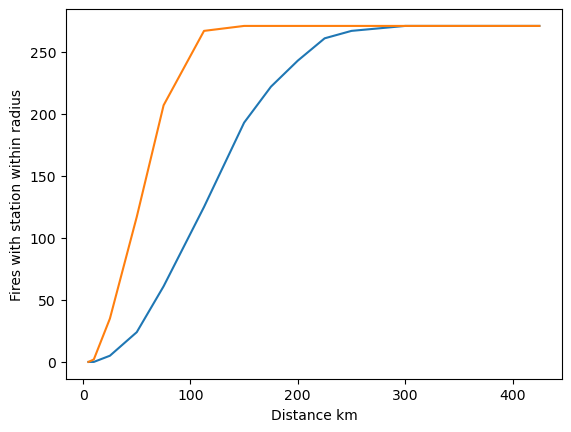

In [32]:
dist_list = [5, 10, 25, 50, 75, 112.654, 150,175, 200, 225, 250, 300, 350, 400, 425]

frs_w_st = []
for d in dist_list:
    df = fire_search(gdf_test, stations = stations, dist_max_km = d)
    frs_w_st.append(len(df.fireID))
    
frs_d_st = []
for d in dist_list:
    df = fire_search(gdf_test, stations = stations2, dist_max_km = d)
    frs_d_st.append(len(df.fireID))
    
plt.plot(dist_list, frs_w_st)
plt.plot(dist_list, frs_d_st)
plt.ylabel("Fires with station within radius")
plt.xlabel("Distance km")

In [7]:
# visualize output for single timestep
gdf_test = gdf
gdf_test["t"] = gdf_test["t"].astype("str")
gdf_test["t_st"] = gdf_test["t_st"].astype("str")
gdf_test["t_ed"] = gdf_test["t_ed"].astype("str")
gdf_test.explore(column='duration')
#gdf_test

NameError: name 'gdf' is not defined

In [15]:
print(gdf.columns)

#?gdf.explore


Index(['isactive', 'isdead', 't_inactive', 'isignition', 'mayreactivate', 't',
       'mergeid', 'ftype', 'n_pixels', 'n_newpixels', 'farea', 'fperim',
       'flinelen', 'duration', 'pixden', 'meanFRP', 't_st', 't_ed', 'geometry',
       'NumPolygons'],
      dtype='object')


['20190501AM', '20190501PM', '20190502AM', '20190502PM', '20190503AM']

In [51]:
# make composite gdf - with a large number of files this will just crash the kernel.
# will take a while to run. maybe don't do it unless you limit the # of files.
gdf = pd.concat([load_file(date,only_lf=True,area_lim=10,show_progress=True) for date in avail_dates[0:25]],
                ignore_index=True)

20190501AM loaded
20190501PM loaded
20190502AM loaded
20190502PM loaded
20190503AM loaded
20190503PM loaded
20190504AM loaded
20190504PM loaded
20190505AM loaded
20190505PM loaded
20190506AM loaded
20190506PM loaded
20190507AM loaded
20190507PM loaded
20190508AM loaded
20190508PM loaded
20190509AM loaded
20190509PM loaded
20190510AM loaded
20190510PM loaded
20190511AM loaded
20190511PM loaded
20190512AM loaded
20190512PM loaded
20190513AM loaded


In [52]:
gdf.set_index(['fireID','t'],inplace=True)
gdf.sort_index(inplace=True)

In [53]:
# find larger fires
pix_cnt = gdf.groupby('fireID')['n_pixels'].max()
print(pix_cnt)
large_ids = pix_cnt[pix_cnt>50].index
gdf_large = gdf.loc[large_ids].reset_index()

fireID
73        7
96       11
448      79
535     185
912       9
1015     69
1282     92
2141      8
Name: n_pixels, dtype: int64


In [54]:
gdf_large.shape


(36, 20)

In [55]:
# a few low pixel count fires are still being displayed...
gdf.reset_index(inplace=True)
gdf.explore(column='t',
                  cmap='jet',
                  style_kwds={'fillOpacity':0})

In [56]:
# now do large fire example
lf_files = glob.glob('/projects/shared-buckets/gsfc_landslides/FEDSoutput-s3-conus/Schaeffer/2017/Largefire/*')

# unique lf ids if more than one, but works with only one too!
lf_ids = list(set([file.split('Largefire/')[1].split('_')[0] for file in lf_files])) 
print('Number of LF ids:',len(lf_ids))

Number of LF ids: 1


In [58]:
# each largefire id has a file for each timestep which has entire evolution up to that point.
# the latest one has the most up-to-date info for that fire
largefire_dict = dict.fromkeys(lf_ids)
for lf_id in lf_ids:
    most_recent_file = [file for file in lf_files if lf_id in file][-1]
    largefire_dict[lf_id] = most_recent_file

In [59]:
# this would capture all large fires in that area
lf_gdf = pd.concat([gpd.read_file(file,layer='perimeter') for key, file in largefire_dict.items()], 
                   ignore_index=True)

In [60]:
lf_gdf.explore(column='t',
               cmap='jet',
               style_kwds={'fillOpacity':0})

In [61]:
# just focus on one now
i = 0
fid = lf_ids[i]
layer = 'perimeter' # options are: fireline, newfirepix, perimeter, or nfplist
gdf = gpd.read_file(largefire_dict[fid],layer=layer)
pixels = gpd.read_file(largefire_dict[fid],layer='nfplist')
m = gdf.explore(column='n_newpixels',
                  cmap='RdBu_r',
                  style_kwds={'fillOpacity':0})
pixels.explore(m=m,
               column='frp',vmax=200,
               cmap='RdBu_r')
folium.LayerControl().add_to(m)
m